# Fig. 4: Centrosome dynamics in WT.
In this notebook we generate panels B, C, F (i,ii,iii) of Figure 4.

We analyse the correlation between spatial and temporal distance of phagocytic events, we investigate the speed of the centrosome and its dynamic behaviour during phagocytosis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import os
import glob
from sklearn.linear_model import LinearRegression

## Assemble dataframe
In the next few cells, we will read in the imaris tracking files and assemble them into one dataframe.

In [2]:
main_path = 'data/3D_centrosome_tracking_wt/tracking_data/'
sample_paths = os.listdir(main_path)

tracks = []
for sample in sample_paths:
    if sample[0] == '.':
        continue
    kmid = sample.split('_')[0]
    if 'Cell' in sample.split('_')[1]:
        cell_number = sample.split('_')[1][-1]
        organelle_type = sample.split('_')[2].lower()
    elif 'Cell' in sample.split('_')[2]:
        cell_number = sample.split('_')[2][-1]
        organelle_type = sample.split('_')[3].lower()
    sid = kmid + 'c' + cell_number
    track_file = os.path.join(main_path, sample, sample[:-10] + 'Position.csv')
    track = pd.read_csv(track_file, skiprows=3).drop(['Unit', 'Category', 'Collection', 'Unnamed: 9'], axis=1).rename({'Position X': 'x', 'Position Y': 'y', 'Position Z': 'z', 'Time': 'time', 'TrackID': 'track id', 'ID': 'id'}, axis=1)
    track['cell number'] = cell_number
    track['km id'] = kmid
    track['sample id'] = sid
    track['type'] = organelle_type
    tracks.append(track)
all_tracks = pd.concat(tracks)
all_tracks['track id'] -= 1E9

Next we categorise the engulfment mode using the file `Cell-body_events.csv`, in which cell body events have been identified manually.

In [3]:
all_tracks['engulfment mode'] = 'branch'

cell_body_events = pd.read_csv('data/3D_centrosome_tracking_wt/Cell-body_events.csv')

for i in cell_body_events.index:
    row = cell_body_events.iloc[i]
    kmid = row['Cell ID'].split('_')[0]
    cell_number = str(row['Cell ID'].split('_')[1][-1])
    tid = row['Track ID'] - 1E9
    all_tracks.loc[(all_tracks['km id'] == kmid) & (all_tracks['cell number'] == cell_number) & (all_tracks['track id'] == tid), 'engulfment mode'] = 'cell body'

    

Now we generate a wide dataframe from this long representation. I.e. we allign the different tracks on time. For this we use the cell-body (cell-soma) cb as reference. For duplicate entries, in cb and cs at a givn timepoint, we choose the spatially closest with regard to the previous point to continue the track.

In [4]:
sdf_list = []
n_double_centrosome = 0

for sid in all_tracks['sample id'].unique():
    sdf = all_tracks.loc[(all_tracks['sample id'] == sid) & (all_tracks['type'] == 'cell-soma')]
    for t in range(sdf['time'].min(), sdf['time'].max()+1):
        n_entries = len(sdf.loc[sdf['time'] == t].index) 
        if n_entries == 0:
            print('time point {} in dataset {} is missing in the cell body data'.format(t, sid))
        elif n_entries > 1:
            print('time point {} in dataset {} has {} entries in the cell body data'.format(t, sid, n_entries))
    sdf = sdf.rename({'x': 'cell body x',
                     'y': 'cell body y',
                     'z': 'cell body z'},
                    axis=1).drop(['track id', 'id', 'type'], axis=1)
    
    csdf = all_tracks.loc[(all_tracks['sample id'] == sid) & (all_tracks['type'] == 'centrosome')]
    cs_coords = np.empty([len(sdf.index), 3])
    cs_coords[:] = np.nan
    for t in range(sdf['time'].min(), sdf['time'].max()+1):
        n_entries = len(csdf.loc[csdf['time'] == t].index) 
        if n_entries == 0:
            print('time point {} in dataset {} is missing in the centrosome data'.format(t, sid))
        elif n_entries > 1:
            n_double_centrosome += 1
            print('time point {} in dataset {} has {} entries in the centrosome data'.format(t, sid, n_entries))
        else:
            cs_coords[t-1, :] = csdf.loc[(csdf['time']==t), list('xyz')].to_numpy()
    sdf['centrosome x'] = cs_coords[:, 0]
    sdf['centrosome y'] = cs_coords[:, 1]
    sdf['centrosome z'] = cs_coords[:, 2]
    sdf = sdf.interpolate()
    if sdf.isnull().values.any():
        print('Interpolation error! Cell body or centrosome data still contains NaNs!')
    
    psdf = all_tracks.loc[(all_tracks['sample id'] == sid) & (all_tracks['type'] == 'phagosomes')]
    n_phagosomes = []
    tids_running = []
    tids = []
    new_event = []
    new_event_coords = np.empty((sdf['time'].max(), 3))
    new_event_coords[:] = np.nan
    time_since_last_event_list = []
    time_since_last_event = -1

    for t in range(sdf['time'].min(), sdf['time'].max()+1):
        time_since_last_event += 1
        time_since_last_event_list.append(time_since_last_event)
        n_entries = len(psdf.loc[psdf['time'] == t].index)
        if n_entries == 0:
            new_event.append(np.nan)
            n_phagosomes.append(0)
            tids.append([])

        else:
            tid = psdf.loc[psdf['time'] == t, 'track id'].to_list()
            new_tids = np.setdiff1d(tid, tids_running)
            tids_running = list(set(tids_running + tid))
            tids.append(tid)
            if len(new_tids) == 0:
                new_event.append(np.nan)

            else:
                if len(new_tids) > 1:
                    print('we found a multiple phagocytic event in time {} of dataset {}'.format(t, sid))
                new_event.append(new_tids[0])

                try:
                    new_event_coords[t-1, :] = psdf.loc[(psdf['time'] == t) & (psdf['track id'] == new_event[-1]), list('xyz')].to_numpy().squeeze()
                except ValueError:
                    print('got {} as track id -> skipping'.format(new_event[-1]))
                time_since_last_event = 0
            n_phagosomes.append(n_entries)
        
    sdf['n phagosomes'] = n_phagosomes
    sdf['phagosome track ids'] = tids
    sdf['phagosome new id'] = new_event
    sdf['phagosome new x'] = new_event_coords[:, 0]
    sdf['phagosome new y'] = new_event_coords[:, 1]
    sdf['phagosome new z'] = new_event_coords[:, 2]

    sdf['time since last phagocytic event'] = time_since_last_event_list
    
    sdf['engulfment mode'] = psdf['engulfment mode']
    sdf_list.append(sdf)
df = pd.concat(sdf_list)
print('We found {} multiple centrosomes in all data.'.format(n_double_centrosome))


time point 48 in dataset km122c4 is missing in the centrosome data
time point 403 in dataset km122c4 is missing in the centrosome data
time point 404 in dataset km122c4 is missing in the centrosome data
time point 405 in dataset km122c4 is missing in the centrosome data
time point 24 in dataset km133c1 is missing in the centrosome data
we found a multiple phagocytic event in time 62 of dataset km133c1
we found a multiple phagocytic event in time 244 of dataset km133c1
got nan as track id -> skipping
time point 161 in dataset km133c3 is missing in the centrosome data
time point 162 in dataset km133c3 is missing in the centrosome data
time point 163 in dataset km133c3 is missing in the centrosome data
time point 164 in dataset km133c3 is missing in the centrosome data
time point 165 in dataset km133c3 is missing in the centrosome data
time point 166 in dataset km133c3 is missing in the centrosome data
time point 167 in dataset km133c3 is missing in the centrosome data
We found 0 multiple

The reported missing data are omitted.

## Calculation of distances, angles and speeds
Here we calculate the distances of the triangle cs-cb-p and the corresponding angles in a vectorised manner. Moreover, we determine the speeds of organelles and categorise the phagocytic events.

Calculating the vector between cell body and centrosome as well as their distance.

In [5]:
df['vector cb-cs x'] = df['centrosome x'] - df['cell body x']
df['vector cb-cs y'] = df['centrosome y'] - df['cell body y']
df['vector cb-cs z'] = df['centrosome z'] - df['cell body z']
df['distance cb-cs'] = np.sqrt(df['vector cb-cs x']**2 + df['vector cb-cs y']**2 + df['vector cb-cs z']**2)

Calculating the vector between the cell body / centrosome and a newly appearing phagosome + distances.

In [6]:
df.loc[df['phagosome new x'] != np.nan, 'vector cb-p x'] = df.loc[df['phagosome new x'] != np.nan, 'phagosome new x'] - df.loc[df['phagosome new x'] != np.nan, 'cell body x']
df.loc[df['phagosome new y'] != np.nan, 'vector cb-p y'] = df.loc[df['phagosome new y'] != np.nan, 'phagosome new y'] - df.loc[df['phagosome new y'] != np.nan, 'cell body y']
df.loc[df['phagosome new z'] != np.nan, 'vector cb-p z'] = df.loc[df['phagosome new z'] != np.nan, 'phagosome new z'] - df.loc[df['phagosome new z'] != np.nan, 'cell body z']

df.loc[df['phagosome new x'] != np.nan, 'vector cs-p x'] = df.loc[df['phagosome new x'] != np.nan, 'phagosome new x'] - df.loc[df['phagosome new x'] != np.nan, 'centrosome x']
df.loc[df['phagosome new y'] != np.nan, 'vector cs-p y'] = df.loc[df['phagosome new y'] != np.nan, 'phagosome new y'] - df.loc[df['phagosome new y'] != np.nan, 'centrosome y']
df.loc[df['phagosome new z'] != np.nan, 'vector cs-p z'] = df.loc[df['phagosome new z'] != np.nan, 'phagosome new z'] - df.loc[df['phagosome new z'] != np.nan, 'centrosome z']

df.loc[df['phagosome new x'] != np.nan, 'distance cb-p'] = np.sqrt(df.loc[df['phagosome new x'] != np.nan, 'vector cb-p x']**2 + df.loc[df['phagosome new x'] != np.nan, 'vector cb-p y']**2 + df.loc[df['phagosome new x'] != np.nan, 'vector cb-p z']**2)
df.loc[df['phagosome new x'] != np.nan, 'distance cs-p'] = np.sqrt(df.loc[df['phagosome new x'] != np.nan, 'vector cs-p x']**2 + df.loc[df['phagosome new x'] != np.nan, 'vector cs-p y']**2 + df.loc[df['phagosome new x'] != np.nan, 'vector cs-p z']**2)

Calculating the speed of the centrosome and the cell body.

## Analysis and Figures

### Fig 4 C: Speed of the centrosome
Here we calculate the normalised speed of the centrosome i.e. its speed relative to the cell body. This way, we normalise for e.g. drift/movement of the cell.

In [7]:
sids = df['sample id'].unique()
for sid in sids:
    sdf = df.loc[df['sample id'] == sid]
    speed_centrosome = np.sqrt(np.gradient(sdf['centrosome x'])**2 + np.gradient(sdf['centrosome y'])**2 + np.gradient(sdf['centrosome z'])**2)
    df.loc[df['sample id'] == sid, 'speed centrosome'] = speed_centrosome * 3 # convert to um/min
    
    speed_cell_body = np.sqrt(np.gradient(sdf['cell body x'])**2 + np.gradient(sdf['cell body y'])**2 + np.gradient(sdf['cell body z'])**2)
    df.loc[df['sample id'] == sid, 'speed cell body'] = speed_cell_body * 3
    
    speed_centrosome_norm = np.sqrt(np.gradient(sdf['vector cb-cs x'])**2 + np.gradient(sdf['vector cb-cs y'])**2 + np.gradient(sdf['vector cb-cs z'])**2)
    df.loc[df['sample id'] == sid, 'speed centrosome normalised'] = speed_centrosome_norm * 3


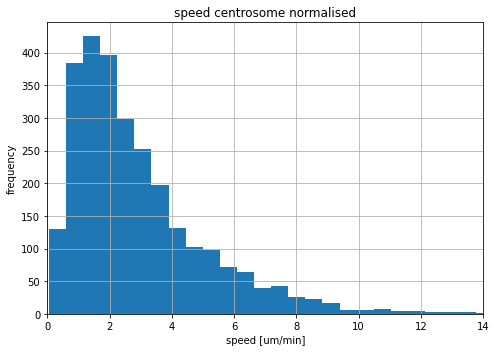

In [8]:
df['speed centrosome normalised'].hist(bins=60, figsize=(7,5))
plt.xlim(0,14)
plt.title('speed centrosome normalised')
plt.xlabel('speed [um/min]')
plt.ylabel('frequency')
plt.tight_layout()


### Generate temporal phagocytosis 'windows'

Calculating the distances between cb-cs-p and corresponding angles for 20 frames before and after each phagocytic even.
If we don't have a location for the phagocytic events, we use the last known position. 

In [9]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in degree between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)) / 2 / np.pi * 360

In [10]:
tids = df['phagosome new id'].unique()[1:] # first entry is nan
sids = df['sample id'].unique()
rows = ['local time', 'global time', 'cell body x', 'cell body y', 'cell body z', 'centrosome x', 'centrosome y', 'centrosome z', 
        'phagosome x', 'phagosome y', 'phagosome z', 'distance cb-cs', 'distance cb-p', 'distance cs-p',
        'angle cell body', 'angle centrosome', 'angle phagosome', 'speed cell body', 'speed centrosome', 'branch mediated engulfment']

# use the tracks of the phagosome (True) or just its initial location
use_phago_tracks = True

rd = dict(zip(rows, list(range(len(rows)))))

p_list = []
engulfment_mode_list = []
for sid in sids:
    for j, tid in enumerate(tids):
        phago_track = all_tracks.loc[(all_tracks['track id'] == tid) & (all_tracks['sample id'] == sid)]
        if phago_track.empty:
            continue
        cell_id = (phago_track['km id']+'_Cell'+ phago_track['cell number']).unique()[0]
        true1 = cell_id in list(cell_body_events['Cell ID'].to_list())
        true2 = tid + 1E9 in list(cell_body_events.loc[(cell_body_events['Cell ID'] == cell_id), 'Track ID'])
        if true1 and true2:
            engulfment_mode_list.append('cell body')
            print(cell_id, tid)
        else:
            if tid == 24750:
                print('??', tid, cell_id)
            engulfment_mode_list.append('branch')
        # initialise array that keeps the infos of one phagocytic even
        phago_array = np.empty([41, len(rows)])
        phago_array[:] = np.nan
        
        # add a local time scale i.e. 20 frames before and after the phagocytic event at t_local = 0
        phago_array[:, rd['local time']] = np.arange(-20, 21, 1)
        
        # add the global time scale i.e. the frame number from the tracking
        t_0_global = phago_track['time'].values[0]
        global_time = np.arange(t_0_global-20, t_0_global+21, 1)
        phago_array[:, rd['global time']] = global_time
        
        # add the coordinates of the cell body and centrosome + thier distances + their speeds
        sdf = df.loc[(df['sample id']==sid) & (df['time'].isin(global_time))].copy()
        sdf['branch mediated engulfment'] = sdf['engulfment mode'] == 'branch'
        for row in ['cell body x', 'cell body y', 'cell body z', 'centrosome x', 'centrosome y', 'centrosome z', 'distance cb-cs', 'speed cell body', 'speed centrosome']:
            idx_t0 = pd.Index(sdf['time']).get_loc(t_0_global)
            idx_last = len(sdf['time'].index) - 1
            lo = 20 - idx_t0
            hi = idx_last + lo + 1
            phago_array[lo:hi, rd[row]] = sdf[row]
               
        phago_array[:, rd['branch mediated engulfment']] = sdf.loc[sdf['time']==t_0_global, 'branch mediated engulfment']
        phago_coords = phago_track.loc[phago_track['type']=='phagosomes', list('xyz')].values
        for i, row in enumerate(['phagosome x', 'phagosome y', 'phagosome z']):
            phago_array[0:21, rd[row]] = phago_coords[0, i] # use the initial location of the phagosome as reference before the track starts
            if use_phago_tracks:
                if len(phago_coords[1:21, i]) < 20:  # use the final coordinate of the phagosome if the track stops prematurely
                    final_coord_idx = len(phago_coords[1:21, i])
                    phago_array[21:21+final_coord_idx, rd[row]] = phago_coords[1:final_coord_idx+1, i]
                    phago_array[21+final_coord_idx:, rd[row]] = phago_coords[final_coord_idx, i]
                else:
                    phago_array[21:, rd[row]] = phago_coords[1:21, i]
            else:
                phago_array[21:, rd[row]] = phago_coords[0, i]
        phago_array[:, rd['distance cb-p']] = np.linalg.norm(phago_array[:, 8:11] - phago_array[:, 2:5], axis=1)
        phago_array[:, rd['distance cs-p']] = np.linalg.norm(phago_array[:, 8:11] - phago_array[:, 5:8], axis=1)
        for i in range(41):
            v_cb_cs = phago_array[i, 5:8] - phago_array[i, 2:5]
            v_cb_p = phago_array[i, 8:11] - phago_array[i, 2:5]
            v_cs_p = phago_array[i, 8:11] - phago_array[i, 5:8]
            phago_array[i, rd['angle cell body']] = angle_between(v_cb_cs, v_cb_p)
            phago_array[i, rd['angle centrosome']] = angle_between(-v_cb_cs, v_cs_p)
            phago_array[i, rd['angle phagosome']] = angle_between(-v_cs_p, -v_cb_p)

        tsle = sdf.loc[sdf['time']==t_0_global , ['time since last phagocytic event']].values.squeeze()
        try:
            next_phago_track = all_tracks.loc[(all_tracks['track id'] == tids[j+1]) & (all_tracks['sample id'] == sid)]
            next_t_0_global = next_phago_track['time'].values[0]
            ttne = df.loc[(df['sample id']==sid) & (df['time']==next_t_0_global), 'time since last phagocytic event'].values[0]
        except IndexError:
            next_sdf = 100       
        if j != 0 and tsle<20:
            phago_array[0:tsle//2, :] = np.nan
        if ttne<20:
            phago_array[ttne//2 + 20:, :] = np.nan
        p_list.append(phago_array)
p_array = np.stack(p_list)


km133_Cell1 261.0
km133_Cell1 307.0
km133_Cell1 496.0
km122_Cell1 336.0
km122_Cell1 612.0
km122_Cell1 806.0
km186_Cell2 1092.0
km186_Cell2 1248.0
km186_Cell4 51.0
km186_Cell4 193.0
km133_Cell3 31678.0


In [11]:
engulfment_mode_list = np.array(engulfment_mode_list)

### Fig 4 B: Relationship between spatial and temporal distance of phagocytosis events.

In [12]:
sdf = df.loc[(df['vector cb-p x'].notnull())]
phagocytic_events_list = []
for sid in sdf['sample id'].unique():
    ssdf = sdf.loc[sdf['sample id'] == sid]
    first = True
    for i, t in enumerate(ssdf['time'].to_list()):
        if first:
            first = False
            continue
        previous = ssdf.loc[ssdf['time']==ssdf['time'].to_list()[i-1]]
        current = ssdf.loc[ssdf['time']==t]
        vector = (current[['phagosome new x', 'phagosome new y', 'phagosome new z']].to_numpy() - previous[['phagosome new x', 'phagosome new y', 'phagosome new z']].to_numpy()).squeeze()
        dist = np.linalg.norm(vector)
        time_since_last_event = (current['time'].values - previous['time'].values)[0]
        mode_current = current['engulfment mode'].values[0]
        mode_previous = previous['engulfment mode'].values[0]
        distance = list(current[['distance cb-p', 'distance cs-p', 'distance cb-cs']].to_numpy().squeeze())
        ndf = pd.DataFrame(data=[[sid, t, dist, time_since_last_event, mode_current, mode_previous] + distance],
                          columns=['sample id', 'time', 'distance to previous phagosome', 'time since last event', 'current engulfment mode',
                                  'previous engulfment mode', 'distance cb-p', 'distance cs-p', 'distance cb-cs'])
        phagocytic_events_list.append(ndf)
df_phago = pd.concat(phagocytic_events_list)

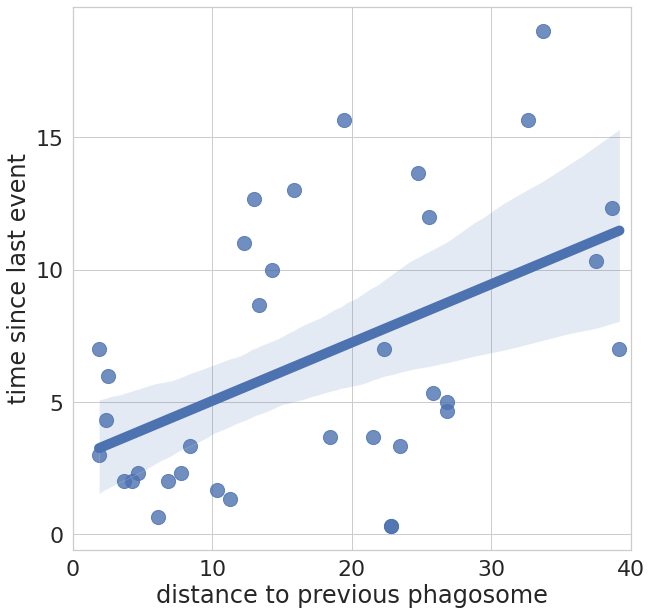

In [13]:
plt.figure(figsize=(10,10))
sns.set(font_scale=2, style='whitegrid')
df_phago_plot = df_phago.loc[(df_phago['time since last event'] < 60) & (df_phago['current engulfment mode'] == 'branch')].copy()
df_phago_plot['time since last event'] = df_phago_plot['time since last event'] * 20 / 60
ax = sns.regplot(data=df_phago_plot,
           x='distance to previous phagosome',
           y='time since last event',
           scatter_kws={'s':200},
           line_kws={'linewidth': 10},
                x_ci='sd')
ax.set_xlim(0,40)
ax.set_xticks([0, 10, 20, 30, 40])
ax.set_yticks([0, 5, 10, 15])


In [14]:
df_phago_plot[['distance to previous phagosome', 'time since last event']].corr()

,distance to previous phagosome,time since last event
distance to previous phagosome,1.000000,0.488651
time since last event,0.488651,1.000000


In [15]:
 import statsmodels.api as sm
x = df_phago_plot['distance to previous phagosome'].values
y = df_phago_plot['time since last event'].values
x = sm.add_constant(x)
model = sm.OLS(y,x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     10.35
Date:                Sat, 06 Aug 2022   Prob (F-statistic):            0.00290
Time:                        20:54:59   Log-Likelihood:                -101.48
No. Observations:                  35   AIC:                             207.0
Df Residuals:                      33   BIC:                             210.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.8408      1.407      2.020      0.0

## Triangular dynamics of phagocytosis

Here, we compute the average dynamic of the triangle cs-cb-p. For that we allign the phagocytosis 'windows' that we generated earlier using the timepoint of phagocytosis as t=0.

In [16]:
def plot_phago(array, xlabel, ylabel, name=None, ax=None, alpha=.3, style='avg', normalise=False,
              sec_per_frame=20):
    
    if ax is None:
        ax = plt.subplots(111)
    
    if normalise:
        from sklearn.preprocessing import MinMaxScaler
        y = array[:, :, rd[ylabel]]
        scaler = MinMaxScaler()
        scaled = scaler.fit_transform(np.swapaxes(y, 0, 1))
        y = np.swapaxes(scaled, 0, 1)        
    else:
        y = array[:, :, rd[ylabel]]
    
    if style == 'full':
        for i in range(array.shape[0]):
            ax.plot(array[i, :, 'local time'],
                    y[i, :],
                    c='gray',
                    alpha=alpha)
        ax.plot(np.arange(-20, 21,1),
                np.nanmean(y, axis=0),
                c='red',
                linewidth=3)
        ax.plot(np.arange(-20, 21,1),
                np.nanmean(y, axis=0) - np.nanstd(y, axis=0),
                c='green',
                linewidth=3)
        ax.plot(np.arange(-20, 21,1),
                np.nanmean(y, axis=0) + np.nanstd(y, axis=0),
                c='green',
                linewidth=3)
    if style == 'avg':
        ax.plot(np.arange(-20, 21,1),
                np.nanmean(y, axis=0),
                #c='red',
                linewidth=4)
        ax.fill_between(np.arange(-20, 21,1),
                        np.nanmean(y, axis=0) - np.nanstd(y, axis=0),
                        np.nanmean(y, axis=0) + np.nanstd(y, axis=0),
                        alpha=.3,
                        #color='green',
                       )
        #ax.plot(np.arange(-20, 21,1),
         #       np.nanmean(array[:, :, rd[y]], axis=0) + np.nanstd(array[:, :, rd[y]], axis=0),
          #      c='green',
           #     linewidth=3)
    if name is None:
        ax.set_title(ylabel)
    else:
        ax.set_title(name)
    ax.set_xlabel(xlabel, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=20)
    ax.set_xlim((-15,15))
    x_ticks = np.array([-15, -7.5, 0, 7.5, 15])
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_ticks/3)
    plt.tight_layout()

### Fig. 4 F i,ii,iii: Centrosomal dynamic relative to cell body and phagosome

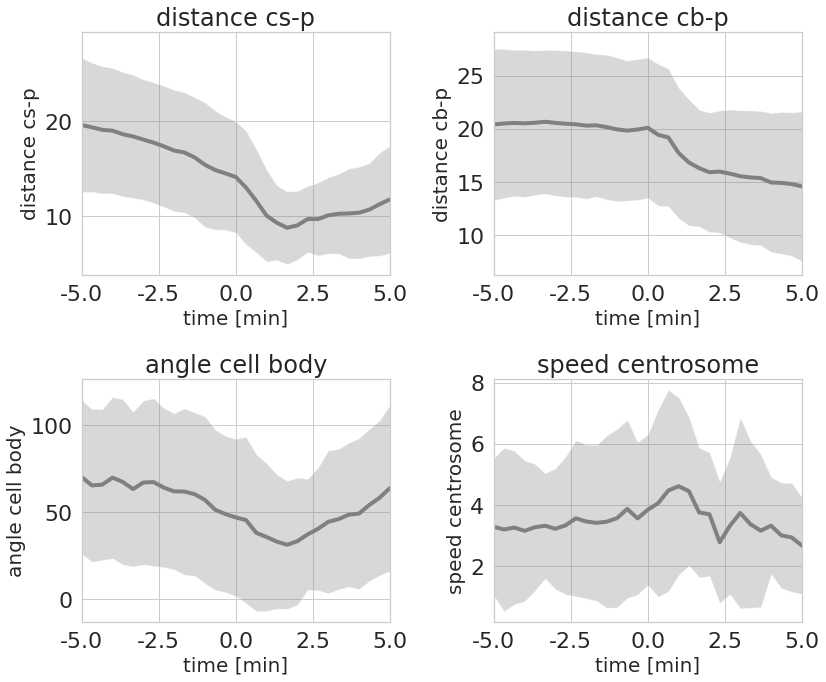

In [17]:
from cycler import cycler
normalise = False

b_array = p_array[engulfment_mode_list == 'branch', :, :] 
alpha = .1

plt.figure(figsize=(12,10))
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)

ax1.set_prop_cycle(cycler('color', ['grey']))
ax2.set_prop_cycle(cycler('color', ['grey']))
ax3.set_prop_cycle(cycler('color', ['grey']))
ax4.set_prop_cycle(cycler('color', ['grey']))

plot_phago(b_array, 'time [min]', 'distance cs-p', ax=ax1, normalise=normalise)
plot_phago(b_array, 'time [min]', 'distance cb-p', ax=ax2, normalise=normalise)
plot_phago(b_array, 'time [min]', 'angle cell body', ax=ax3, normalise=normalise)
plot_phago(b_array, 'time [min]', 'speed centrosome', ax=ax4)

